# Multivariate Gaussians, K-means and Gaussian Mixture Models

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sklearn.datasets
import pylab
from matplotlib.patches import Ellipse


# Generate data
We'll generate data from a mixture of Gaussians model by generating data from three separate Gaussians and concatenating the data. We'll do everything in 2 dimensions so that we can visualise things easily.

In this tutorial, we'll sometimes avoid using a built in function, and instead do things the "long way" to get some extra exposure to some basic maths and statistics.

Using the `np.random.randn` command we can generate data from a standard multivariate normal, and using `matplotlib` we can visualise this.

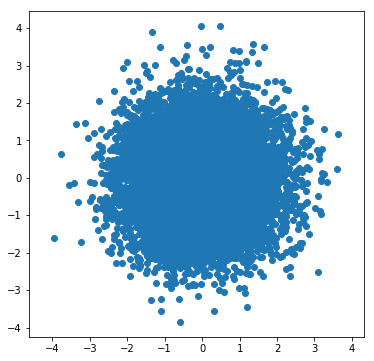

In [2]:
# Generate data
num_data = 10000
dimensions = 2
data = np.random.randn(num_data,dimensions)

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(data[:,0], data[:,1])
plt.axis('equal')
plt.show()

Just as a quick sanity check, we can make sure that the mean and covariance of the data we just generated is what we expect:

In [3]:
print np.mean(data[:,0])
print np.mean(data[:,1])
print np.cov(data.T)

-0.0123484576753
-0.0148022033307
[[ 0.99082741  0.00706382]
 [ 0.00706382  0.99911906]]


Great! These numbers are roughly what we would expect, given that the population mean is `0` and the population covariance is the `2x2` identity matrix. You can try increasing `num_data` and verify that the empirical mean and covariance get closer to the population values.

Now, let's use the function `np.random.randn` to generate data from non-standard Gaussians.

Let's suppose that $Z \sim \mathcal{N}\left(0, I_n\right)$ is a standard Gaussian, and we'll define a new variable $X$ as:

$$ X = \Sigma^{1/2} Z + \mu $$

where $\Sigma$ is a _symmetric_ $n\times n$ matrix and $\mu$ is a vector of size $n$.

By closure of Gaussians under linear operations, $X$ is still Gaussian and its distribution is therefore determined by its mean and covariance, which we can simply calculate.

$$ 
\begin{align}
\mathbb{E}[X] &= \Sigma^{1/2}\mathbb{E}[Z] + \mu \\
              &= \mu \\
\mathbb{C}[X] &= \mathbb{E}[XX^\intercal] - \mathbb{E}[X]\mathbb{E}[X]^{\intercal} \\
              &= \Sigma^{1/2}\mathbb{E}[ZZ^\intercal]\Sigma^{1/2} + \mu \mu^\intercal - \mu \mu^\intercal\\
              &= \Sigma
\end{align}
$$

Therefore, $X \sim \mathcal{N}\left(\mu, \Sigma\right)$. Using this fact we can write a function to generate samples from arbitrary Gaussians.

Note that because we store our data in a matrix where each _row_ corresponds to a single observation, we multiply by the square root of the covariance matrix on the right rather than the left in the function below.

In [4]:
def sample_gaussian(mean, covariance, n_data, dimensions=2):
    assert mean.shape == (dimensions,)
    assert covariance.shape == (dimensions, dimensions)
    sqrt_cov = scipy.linalg.sqrtm(covariance)
    data = np.random.randn(n_data, dimensions)
    return np.dot(data, sqrt_cov) + mean

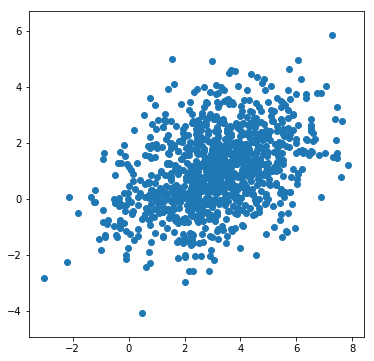

In [5]:
mean1 = np.array([3,1])
cov1 = np.array([[3,1],[1,2]])
data1 = sample_gaussian(mean1, cov1, 1000)

plt.figure(figsize=(6, 6))
plt.scatter(data1[:,0], data1[:,1])
plt.axis('equal')
plt.show()

Again as a sanity check we can calculate the empirical mean and covariances of the data we just generated to see that they match what we expect.

In [6]:
print np.mean(data1[:,0])
print np.mean(data1[:,1])
print np.cov(data1.T)

3.07562386296
1.02746883564
[[ 2.92964863  0.94634928]
 [ 0.94634928  1.9995487 ]]


Let's generate a few different clusters and plot them together.

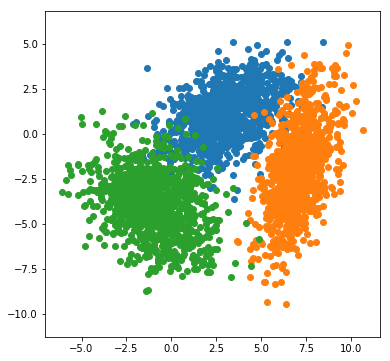

In [7]:
mean1 = np.array([3,1])
cov1 = np.array([[3,1],[1,2]])
data1 = sample_gaussian(mean1, cov1, 1000)

mean2 = np.array([7,-2])
cov2 = np.array([[1,1],[1,5]])
data2 = sample_gaussian(mean2, cov2, 1000)

mean3 = np.array([-1,-4])
cov3 = np.array([[3,-1],[-1,3]])
data3 = sample_gaussian(mean3, cov3, 1000)



plt.figure(figsize=(6, 6))
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.scatter(data3[:,0], data3[:,1])
plt.axis('equal')
plt.show()

# K-means 
Now that we have some data generated, let's do some clustering. We're going to implement one of the most basic clustering algorithms: K-means.

The basic idea here is that we are going to start with an initial seed of $K$ points in the data-space. These are the centres of $K$ distinct clusters. We then iterate, first assigning each datum to the cluster whose centre is nearest to it, and then updating the $K$ points by setting each to be the average of all of the data assigned to it.

More formally, we start with $K$ points $m_1, \ldots, m_K$ and some data $x_1,\ldots, x_N$. Then, we iteratively apply each of the following steps:

$1)$ Find, for each $k$, $S_k= \lbrace x_n : d(x_n,m_k) \leq d(x_n, m_i) \: \forall i \rbrace$

$2)$ Update the cluster centres: $m_k = \frac{1}{|S_k|} \sum_{x_n \in S_k} x_n$

We apply these steps until convergence occurs. We could define this, for instance, as occurring when cluster assignments do not change.

We'll write two functions, one for each of the steps above.

In [8]:
def update_cluster_assignments(data, m):
    # returns a dictionary mapping index i to numpy array of data that are nearest to m[i]
    clusters = {}
    for i in range(len(m)):
        clusters[i] = []
    for x in data:
        # find index i of nearest m[i] and append it to cluster
        clusters[np.sum((m-x)**2, 1).argmin()].append(x)
    for i in range(len(m)):
        clusters[i] = np.array(clusters[i])
    return clusters
        
def update_cluster_means(clusters):
    # returns the updated cluster means
    n_clusters = len(clusters)
    dimension = len(clusters[0][0])
    m = np.zeros([n_clusters, dimension])
    for i in clusters:
        # calculate the mean of points assigned to cluster i
        m[i] = np.mean(clusters[i], 0)
    return m
    

Let's try out the functions that we've written on the data we generated earlier. We'll concatenate all our data together into one big matrix, try some initial seeds for the centres and find the corresponding clusters. We can visualise this by slightly modifying the code to plot from before (we'll put it in a function as we'll use it again later).

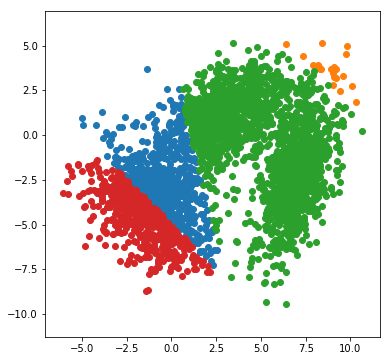

In [9]:
data = np.concatenate([data1, data2, data3])
m = np.array([[0,0],[10,10],[2,0.5],[-5,-5]])
clusters = update_cluster_assignments(data, m)


def plotter(clusters):
    # Plot data, colored by cluster
    plt.figure(figsize=(6, 6))
    for i in range(len(clusters)):
        plt.scatter(clusters[i][:,0], clusters[i][:,1])
    plt.axis('equal')
    plt.show()
    
plotter(clusters)

Let's update the mean once and the update the clusters.

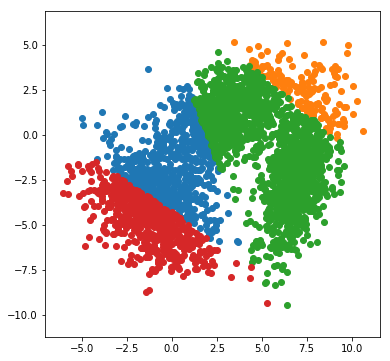

In [10]:
m = update_cluster_means(clusters)
clusters = update_cluster_assignments(data, m)
plotter(clusters)

The clusters changed! Great. $k$-means works by repeatedly performing the two update functions we just called, so let's write a wrapper function to do this, terminating when the cluster centers have stopped changing. 

In [11]:
def kmeans(data, k, eps=None):
    # If initial cluster centres are not provided, randomly select k data points to be the centres
    m = data[np.random.choice(range(len(data)), k, replace=False)]
    m_old = m
    clusters = update_cluster_assignments(data, m)
    m = update_cluster_means(clusters)
    
    # Stop once the cluster centres stop changing
    while (m_old != m).any():
        m_old = m
        clusters = update_cluster_assignments(data, m)
        m = update_cluster_means(clusters)
        
    return clusters

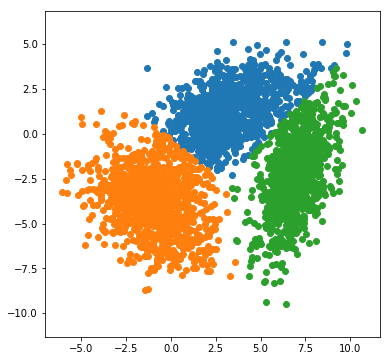

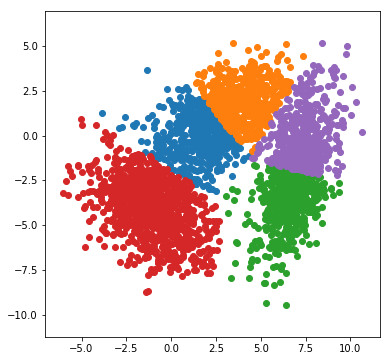

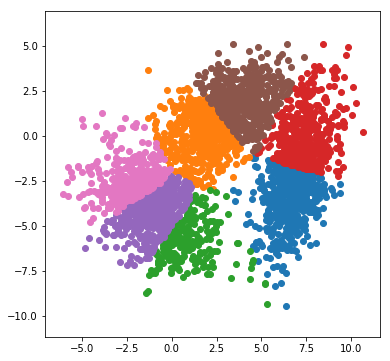

In [12]:
plotter(kmeans(data, 3))
plotter(kmeans(data, 5))
plotter(kmeans(data, 7))

## Trying this out on some real data
We'll run our freshly written $k$-means algorithm on the Iris dataset

In [13]:
iris = sklearn.datasets.load_iris()
iris_data = iris.data
iris_clusters = kmeans(iris_data,3)

Since the iris dataset is 4-dimensional, we can't visualise all of it at once. We can compare each of the 6 pairs of dimensions separately:

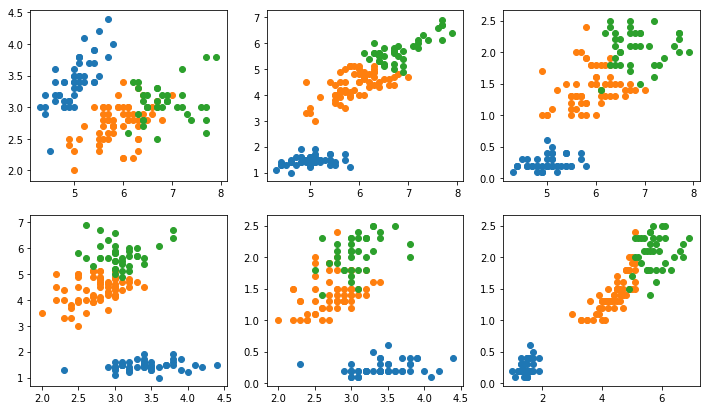

In [14]:
number_of_subplots=6
v=0
plt.figure(figsize=(12, 22))
plt.axis("equal")
for j in range(3):
    for k in range(j+1, 4):
        v += 1

        ax1 = pylab.subplot(number_of_subplots,3,v)
        for i in range(len(iris_clusters)):
            ax1.scatter(iris_clusters[i][:,j], iris_clusters[i][:,k])

plt.show()

# Principal Component Analysis (PCA)

Plotting each pair of dimensions separately is not very satisfying, as it's hard to piece together what each plot shows separately into a single explanation. We can use Principal Component Analysis (PCA) to instead find the most informative 2D subspace to project our data onto before visualising. 

PCA is a useful pre-processing algorithm that projects data to a lower dimensional subspace while maintaining the maximum variance within the data. We'll apply this here, projecting the 4-dimensional Iris dataset to a 2-dimensional space so that we can see our clusters better.

Before applying PCA, we have to standardise our data, since different measurement units in different dimensions can mess things up.

In [15]:
iris_data_std = iris_data.copy()
for i in range(len(iris_data[0])):
    iris_data_std[:,i] = (iris_data_std[:,i] - iris_data[:,i].mean()) / iris_data[:,i].std()

Next, we calculate the directions of maximal variance within the data by finding the eigenvectors of the covariance matrix. We'll then stack the two eigenvectors corresponding to the largest eigenvalues, giving us a matrix that will project our 4D data onto the 2D subspace with largest variance.

The next plot shows the data in the projected space coloured by the true class label.

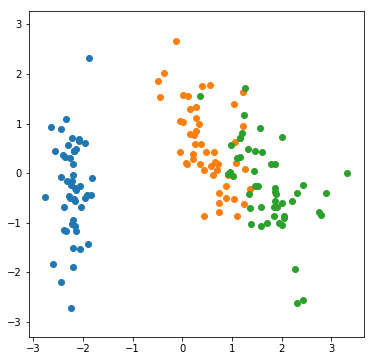

In [16]:
# Calculate eigenvalues
eig_vals, eig_vecs = np.linalg.eig(np.cov(iris_data_std.T))

# Project data onto lower dimensional subspace
proj_matrix = eig_vecs[:,0:2]
proj_data = iris_data_std.dot(proj_matrix)

# Plot all data coloured by class label
plt.figure(figsize=(6, 6))
for col in range(3):
    plt.scatter(proj_data[:,0][iris.target==col], proj_data[:,1][iris.target==col])
plt.axis('equal')
plt.show()

Now let's take the clusters we found using $k$-means, project each of them to the 2D subspace, and plot.

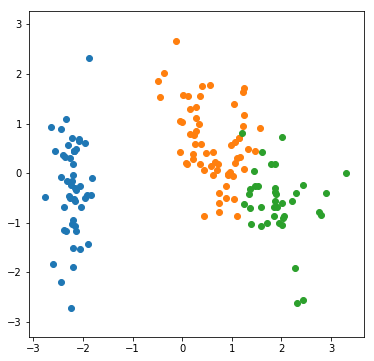

In [17]:
# Plot data, colored by cluster
plt.figure(figsize=(6, 6))
for i in range(len(iris_clusters)):
    cluster_data = iris_clusters[i].copy()
    # we have to apply the same standardisation transformation as we did to the original data before doing PCA
    for j in range(len(cluster_data[0])):
        cluster_data[:,j] = (cluster_data[:,j] - iris_data[:,j].mean()) / iris_data[:,j].std()
    proj_cluster = cluster_data.dot(proj_matrix)
    plt.scatter(proj_cluster[:, 0], proj_cluster[:, 1])
plt.axis('equal')
plt.show()

As you can see, we do a fairly good job at separating the data into the correct classes!

# Gaussian Mixture Model

Let's now work towards building up to a probabilistic generalisation of $k$-means known as a _Gaussian Mixture Model_. $k$-means is great for its simplicity, but it suffers from (at least) the following two problems:

1) Each datum is given a "hard" assignment to a cluster. If for example a datum straddles the boundary of two clusers, we might in fact want to express an uncertain belief of which cluster the datum belongs to.

2) The only thing that is important in determining which cluster a datum belongs to is which centre it is nearest to. The shape of the cluster is not taken into account at all, leading to somewhat strage clusterings such as the one below.

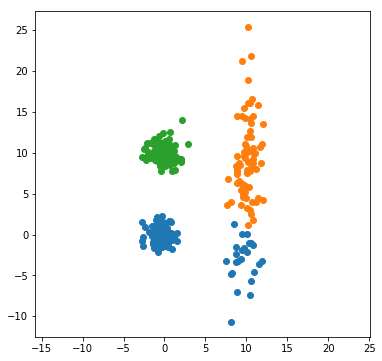

In [18]:
mean1 = np.array([0,0])
cov1 = np.array([[1,0],[0,1]])
data1 = sample_gaussian(mean1, cov1, 100)

mean2 = np.array([0,10])
cov2 = np.array([[1,0],[0,1]])
data2 = sample_gaussian(mean2, cov2, 100)

mean3 = np.array([10,5])
cov3 = np.array([[1,0],[0,50]])
data3 = sample_gaussian(mean3, cov3, 100)

clusters = kmeans(np.concatenate([data1, data2, data3]), 3)
plotter(clusters)

In the case above, we'd really want to have three clusters - the two circles on the left, and the long sausage on the right. However, because the sausage is very long, the points near the ends will be closer to the circles than the sausage centre. The Gaussian Mixture Model will come to our rescue.

## The generative model

In a Gaussian Mixture Model (henceforth GMM) we assume that there are $K$ distinct classes, each of which follow different Gaussian distributions with parameters $\mu_k$ and $\Sigma_k$. We assume a prior discrete distribution $Dis(\pi)$ with parameter $\pi$ over the class $s$ for each datum.

$$ 
\begin{align*}
s_i & \sim Dis(\pi) \\
X_i & \sim \mathcal{N}\left( \mu_{s_i}, \Sigma_{s_i}\right)
\end{align*}
$$

Here's some code that can generate data from this model.

In [19]:
def sample_GMM(mu, sigma, pi, num_data):
    # mu, sigma and pi are lists of length k
    assert len(mu) == len(sigma)
    assert len(mu) == len(pi)
    
    K = len(mu)
    D = len(mu[0])
    X = np.zeros([num_data, D])
    
    # random sample from multinomial distribution to see how many samples we should generate for each class
    class_nums = np.random.multinomial(num_data, pi)
    for k in range(K):
        # Fill in X in order of classes.... we do this so that we only have to call sample_gaussian K times
        lower = sum(class_nums[0:k])
        upper = sum(class_nums[0:k+1])
        X[lower:upper,:] = \
                   sample_gaussian(covariance=sigma[k], mean=mu[k], n_data=class_nums[k])
    
    # Shuffle rows of X so that classes are not in order
    np.random.shuffle(X)
    return X
    

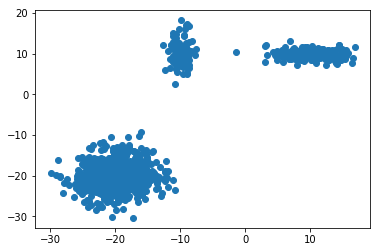

In [20]:
mu = [np.array([-20,-20]), np.array([10,10]), np.array([-10,10])]
sigma = [np.array([[10,0],[0,10]]), np.array([[10,0],[0,1]]), np.array([[1,0],[0,10]])]
pi = [0.7, 0.2, 0.1]

X = sample_GMM(mu, sigma, pi, 1000)

plt.scatter(X[:,0], X[:,1])
plt.show()

Given any observation $X_i$ and values for the parameters $\pi, \mu_k, \Sigma_k$ for all $k$, we can calculate the posterior probability that $X_i$ belongs to class $k$ using Bayes' rule:

$$ 
\begin{align*}
P(s_i = k | X_i) &= \frac{P(X_i | s_i = k) P(s_i = k)}{P(X_i)} \\
                 &\propto \mathcal{N}\left(X_i | \mu_k, \Sigma_k \right) \pi_k
\end{align*}
$$


How should we choose the values for the parameters $\pi, \mu_k$ and $\Sigma_k$? We'll optimise the margingal likelihood (the probability of the data given the parameters). To make the maths a bit simpler, we'll actually consider the marginal log-likelihood. This has the advantage of products into sums (making things more numerically stable when we would otherwise have the product of lots of small probabilities), and since $log$ is a monotonically increasing function, maximising the marginal log-likelihood will give the same parameters as maximising the marginal likelihood.

$$ 
\begin{align*}
\log P(X |\pi, \mu, \Sigma) &=  \sum_{i=1}^{N} \log P(X_i |\pi, \mu, \Sigma) \\ 
                           &=  \sum_{i=1}^{N} \log \left( \sum_k P(X_i |\mu_k, \Sigma_k) P(s_i = k)  \right) \\
                           &=  \sum_{i=1}^{N} \log \left( \sum_k \mathcal{N}(X_i |\mu_k, \Sigma_k) \pi_k  \right)
\end{align*}
$$

Unfortunately, this would be difficult to directly optimise. Instead, we can use the **EM algorithm**  to optimise a lower bound on this. 

# The EM algorithm

We'll breifly explain the EM algorithm here. For models with latent varibles such as the above GMM, it can be difficult to optimise the marginal log-likelihood with respect to the parameters. However, if we knew the latent variables for each observation, this would be easy. Similarly, if we knew the parameters, then finding the latent variables for each observations would be easy. EM works by iteratively performing these two updates, optimising a lower bound on the log-likelihood called the _Free Energy_. The Free Energy is a function of the parameters $\theta$ of the model and an approximating distribution $Q(Y)$ for the posteriors over the latents:

$$
\begin{align*}
\log P(X | \theta) &= \log \int P(X, Y | \theta) dY \\
                   &= \log \int  \frac{P(X, Y| \theta)}{ Q(Y)} Q(Y) dY \\
                   &\geq \int  \log \left(\frac{P(X, Y| \theta)}{ Q(Y)}\right) Q(Y) dY =: F(Q,\theta)
\end{align*}
$$

In an __Expectation__ step, we maximise $F$ with respect to $Q$, keeping $\theta$ fixed. Noting that

$$
\begin{align*}
F(Q,\theta) &= \int  \log \left(\frac{P(X, Y| \theta)}{ Q(Y)}\right) Q(Y) dY \\
            &= \int  \log \left( \frac{P(Y|X, \theta) P(X|\theta)}{Q(Y)} \right) Q(Y) dY \\
            &= \log P(X|\theta) + \int  \log \left( \frac{P(Y|X, \theta)}{Q(Y)} \right) Q(Y) dY \\
            &= \log P(X|\theta) - KL\left[Q(Y) || P(Y|X, \theta) \right]\\
\end{align*}
$$

Since KL divergences are always greater than zero, maximising $F$ with respect to $Q$ reduces to minimising the KL on the right hand side. This term equals zero if and only if $Q(Y)$ is set to be the posteriors of the latents given the current parameters.

In a __Maximisation__ step, we maximise $F$ with respect to $\theta$, keeping $Q$ fixed. Noting that 


$$
\begin{align*}
F(Q,\theta) &= \int  \log \left(\frac{P(X, Y| \theta)}{ Q(Y)}\right) Q(Y) dY \\
            &= \int  \log \left( P(X, Y| \theta) \right) Q(Y) dY - \int  \log \left(Q(Y)\right) Q(Y) dY \\
            &= \mathbb{E}_{Y\sim Q} \left[\log P(X, Y| \theta)\right]  + H[Q]
\end{align*}
$$


where $H[Q]$ is the _entropy_ of $Q$, we see maximising $F$ with respect to $\theta$ reduces to maximising $\mathbb{E}_{Y\sim Q} \left[\log P(X, Y| \theta)\right]$

## EM for GMM

It's relatively straightforward to derive the E and M updates for the Gaussian Mixture Model.

__E-step__:

For the $i$th datum $X_i$, the posterior probability it belongs to class $k$ is 


$$ 
\begin{align*}
P(s_i = k | X_i) &= \frac{P(X_i | s_i = k) P(s_i = k)}{P(X_i)} \\
                 &\propto \mathcal{N}\left(X_i | \mu_k, \Sigma_k \right) \pi_k
\end{align*}
$$

We'll write $r_{ik} = P(s_i = k | X_i)$ for shorthand (r stands for _responsibility)

__M-step__:

Given the posteriors over the latents, we have that.... TODO: tidy this up...
$$
\begin{align*}
\mathbb{E}_{Y\sim Q} \left[\log P(X, Y| \theta)\right] &= \sum_{i,k} r_{ik} \log\left( \pi_k \mathcal{N}(X_i| \mu_k, \Sigma_k) \right) \\
&= \sum_{i,k} r_{ik} \left[ \log(\pi_k) - \log( + \left( (X_i - \mu_k) \Sigma_k^{-1} (X_i - \mu_k)^{\intercal} \right) \right]\\
\end{align*}
$$

$$\pi_k = \frac{\sum_i r_{ik}}{\sum_{ik} r_{ik}}$$

$$ \mu_k = \frac{\sum_i r_{ik} X_i}{\sum_i r_{ik}} $$

$$\Sigma_k = \frac{\sum_i r_{ik} \left(X_i - \mu_k \right)\left(X_i - \mu_k \right)^\intercal}{\sum_i r_{ik}} $$


The following code implements these updates, which we can wrap together into a function to iteratively perform these updates until all of the parameters have stopped changing.

In [21]:
def E_step(X, pi, mu, Sigma):
    K = len(pi)
    N = len(X)
    r = np.zeros([N,K])
    
    # for each component, calculate probability density for all X...
    for k in range(K):
        r[:,k] = scipy.stats.multivariate_normal.pdf(cov=Sigma[k], mean=mu[k], x=X)
    # ... then normalise each row
    r = r / r.sum(axis=1)[:,None]
    return r
    
def M_step(X, r):
    N = len(r)
    K = len(r[0])
    
    pi = list(r.sum(axis=0) / r.sum())
    mu = list((r.T).dot(X)/r.sum(axis=0)[:,None])
    Sigma = [None]*K
    
    for k in range(K):
        mu_k = mu[k]
        Sigma[k] = ((r[:,k][:,None]*(X - mu[k])).T).dot(X-mu[k])/ r[:,k].sum()
    return pi, mu, Sigma


def fit_GMM(X, K):
    # K = number of components
    # Initialise means to be random K data points
    mu = list(X[np.random.choice(len(X),K,replace=False)])
    sigma = [5*np.identity(len(X[0]))] * K
    pi = [1./K] * K
    

    r = E_step(X, pi, mu, sigma)
    
    mu_old = mu
    sigma_old = sigma
    pi_old = pi
    r_old = r    
    
    pi, mu, sigma = M_step(X, r)    

    while ((np.array(mu_old) - np.array(mu))**2).sum() + \
                ((np.array(sigma_old) - np.array(sigma))**2).sum() + \
                ((np.array(pi_old) - np.array(pi))**2).sum() + \
                ((np.array(r_old) - np.array(r))**2).sum()> 1e-25:
        mu_old = mu
        sigma_old = sigma
        pi_old = pi
        r_old = r    
        
        r = E_step(X, pi, mu, sigma)
        pi, mu, sigma = M_step(X, r)
        

    return pi, mu, sigma
    

We'll also write a plotting function that will help us visualise the clusters that we find.

In [22]:
def plotter_GMM(X, mu, sigma):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X[:,0], X[:,1])
    for k in range(len(mu)):
        eigvals, eigvecs = np.linalg.eig(sigma[k])
        eigvals = np.sqrt(eigvals)
        ell = Ellipse(xy=mu[k],
                      width=eigvals[0]*4, height=eigvals[1]*4,
                      angle=np.rad2deg(np.arccos(eigvecs[0, 0])),
                      color='black')
        ell.set_facecolor('none')
        ax.add_artist(ell)

    plt.axis('equal')
    plt.show()

[0.30699999999589705, 0.34552031722772703, 0.34747968277637586]


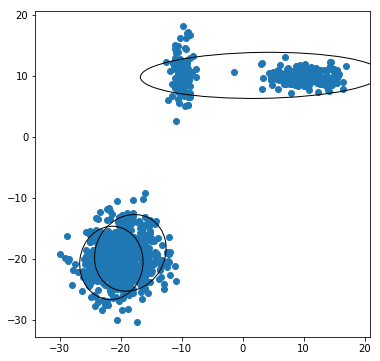

In [23]:
np.random.seed(0)
pi, mu, sigma = fit_GMM(X, 3)
print pi

plotter_GMM(X, mu, sigma)

Note that the clusters that our algorithm finds are highly dependent on the initial choice of parameters. In the above case, it would appear that two of the initial cluster seeds were chosen to be from one of the clusters, and since EM is vulnerable to be stuck in local minimima, it is not able to move either of the centres away. 

A sensible idea would be to try multiple choices for initial values. At the end of each iteration, we could calculate the marginal log-likelihood corresponding to the choice of parameters we found, and choose the final parameters that give the largest marginal log-likelihood.

When we have a good choice of initial parameters though, the algorithm appears to perform well:

[0.69300000000001472, 0.19900000514436011, 0.10799999485562518]


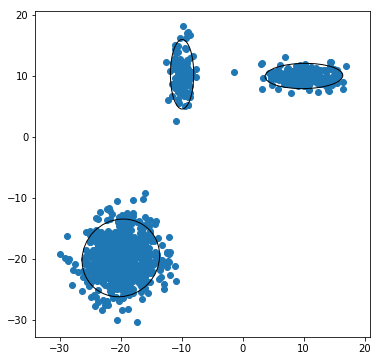

In [37]:
np.random.seed(7)
pi, mu, sigma = fit_GMM(X, 3)
print pi

plotter_GMM(X, mu, sigma)

Also, we see that the earlier problem with $k$-means is resolved using our more advanced GMM:

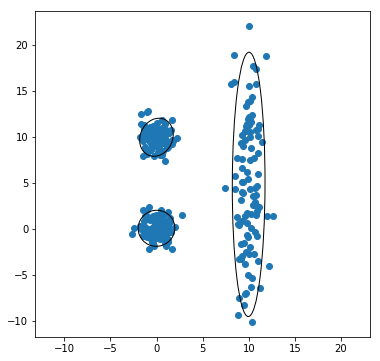

In [38]:
mean1 = np.array([0,0])
cov1 = np.array([[1,0],[0,1]])
data1 = sample_gaussian(mean1, cov1, 100)

mean2 = np.array([0,10])
cov2 = np.array([[1,0],[0,1]])
data2 = sample_gaussian(mean2, cov2, 100)

mean3 = np.array([10,5])
cov3 = np.array([[1,0],[0,50]])
data3 = sample_gaussian(mean3, cov3, 100)

data = np.concatenate([data1, data2, data3])
pi, mu, sigma = fit_GMM(data, 3)
plotter_GMM(data, mu, sigma)